In [1]:
from qiskit import QuantumCircuit, transpile
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2
from qiskit.circuit import Delay
from qiskit.quantum_info import Operator
from qiskit_aer import Aer, AerSimulator
import numpy as np

import sys
import os

sys.path.append(os.path.abspath("..\\..\\..\\.."))
from metrics.IBM.get_calibration_data import get_calibration_data, get_best_qubits


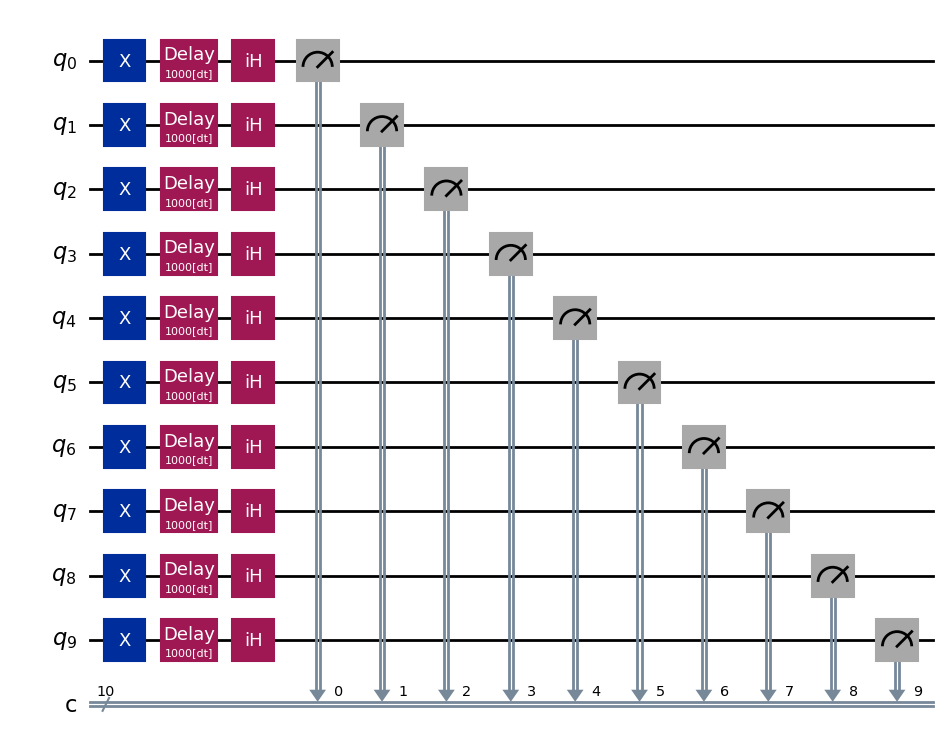

In [2]:

ih_matrix = 1/np.sqrt(2) * np.array([[1, -1j], [1j, -1]])
# hadamard para {0,1} <-> {+i,-i}

def load_circuit(delay, qb_len=1):
    qc = QuantumCircuit(qb_len, qb_len)

    qc.x(range(qb_len)) # estado inicial 1
    for i in range(qb_len):
        if delay > 0:
            qc.append(Delay(delay), [i])
        qc.unitary(Operator(ih_matrix), [i], label='iH')  # medir en base +-i
    qc.measure(range(qb_len), range(qb_len))
    
    return qc

qc = load_circuit(1000, 10)
qc.draw('mpl')


(-0-0.707j)
(-0.707+0j)


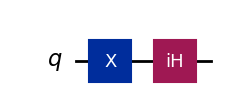

In [3]:
def statevector_simulation(circuit):
    simulator = AerSimulator()
    qct = transpile(circuit, simulator)

    state = np.asarray(Aer.get_backend('statevector_simulator').run(qct, shots=1).result().get_statevector())

    for s in state:
        print(np.round(s,3))

test_circuit = QuantumCircuit(1)
test_circuit.x(0)
test_circuit.unitary(Operator(ih_matrix), [0], label='iH')  # medir en base +-i

statevector_simulation(test_circuit)
test_circuit.draw('mpl')

In [4]:
ibm_token = ""
service = QiskitRuntimeService(channel="ibm_quantum", token=ibm_token)
backend = service.backend("ibm_brisbane")
data_csv = 'ibm_brisbane_calibrations_2025-01-06T20_44_22Z.csv'

In [5]:
best_T1_qubits = get_best_qubits(data_csv, lambda x: x.T1, 10)
print(*[f"{q.Qubit}, T1={round(q.T1, 3)}" for q in best_T1_qubits], sep= '\n')

23, T1=440.358
27, T1=414.128
50, T1=389.54
29, T1=381.151
9, T1=363.236
30, T1=357.955
49, T1=350.983
84, T1=346.938
18, T1=337.182
17, T1=336.885


In [6]:
isa_circuit = transpile(qc, backend, scheduling_method="asap", optimization_level=3, initial_layout=[q.Qubit for q in best_T1_qubits])
print(f"Circuit Depth: {qc.depth()}")
print(f"Transpiled Circuit Depth: {isa_circuit.depth()}")
# isa_circuit.draw(output='mpl')

Circuit Depth: 4
Transpiled Circuit Depth: 5


In [7]:
dt = backend.configuration().dt * 10**9
print(f'dt = {round(dt, 3)} ns')

dt = 0.5 ns


In [8]:
t_array = [t*5_000 for t in range(0, 81)]
print([round(t*dt * 10**(-3),2) for t in t_array])

[0.0, 2.5, 5.0, 7.5, 10.0, 12.5, 15.0, 17.5, 20.0, 22.5, 25.0, 27.5, 30.0, 32.5, 35.0, 37.5, 40.0, 42.5, 45.0, 47.5, 50.0, 52.5, 55.0, 57.5, 60.0, 62.5, 65.0, 67.5, 70.0, 72.5, 75.0, 77.5, 80.0, 82.5, 85.0, 87.5, 90.0, 92.5, 95.0, 97.5, 100.0, 102.5, 105.0, 107.5, 110.0, 112.5, 115.0, 117.5, 120.0, 122.5, 125.0, 127.5, 130.0, 132.5, 135.0, 137.5, 140.0, 142.5, 145.0, 147.5, 150.0, 152.5, 155.0, 157.5, 160.0, 162.5, 165.0, 167.5, 170.0, 172.5, 175.0, 177.5, 180.0, 182.5, 185.0, 187.5, 190.0, 192.5, 195.0, 197.5, 200.0]


In [9]:

circuits = []

for t in t_array:

    qc = load_circuit(t, qb_len=10)

    isa_circuit = transpile(qc, backend, scheduling_method="asap", optimization_level=3, initial_layout=[q.Qubit for q in best_T1_qubits])
    circuits.append(isa_circuit)

    print(f"Circuit Depth: {circuits[-1].depth()}")
    print(f"Delay Duration: {round(t*dt * 10**(-3), 3)} μs")
    print(f"Total Duration: {round(circuits[-1].duration*dt * 10**(-3), 3)} μs\n")
    # c.draw(output='mpl')

Circuit Depth: 3
Delay Duration: 0.0 μs
Total Duration: 1.36 μs

Circuit Depth: 5
Delay Duration: 2.5 μs
Total Duration: 3.92 μs

Circuit Depth: 5
Delay Duration: 5.0 μs
Total Duration: 6.42 μs



C:\Users\marzu\AppData\Local\Temp\ipykernel_50440\3846631322.py:12: DeprecationWarning: The property ``qiskit.circuit.quantumcircuit.QuantumCircuit.duration`` is deprecated as of qiskit 1.3.0. It will be removed in Qiskit 2.0.0.
  print(f"Total Duration: {round(circuits[-1].duration*dt * 10**(-3), 3)} μs\n")
C:\Users\marzu\AppData\Local\Temp\ipykernel_50440\3846631322.py:12: DeprecationWarning: The property ``qiskit.circuit.quantumcircuit.QuantumCircuit.duration`` is deprecated as of qiskit 1.3.0. It will be removed in Qiskit 2.0.0.
  print(f"Total Duration: {round(circuits[-1].duration*dt * 10**(-3), 3)} μs\n")
C:\Users\marzu\AppData\Local\Temp\ipykernel_50440\3846631322.py:12: DeprecationWarning: The property ``qiskit.circuit.quantumcircuit.QuantumCircuit.duration`` is deprecated as of qiskit 1.3.0. It will be removed in Qiskit 2.0.0.
  print(f"Total Duration: {round(circuits[-1].duration*dt * 10**(-3), 3)} μs\n")
C:\Users\marzu\AppData\Local\Temp\ipykernel_50440\3846631322.py:12: De

Circuit Depth: 5
Delay Duration: 7.5 μs
Total Duration: 8.92 μs

Circuit Depth: 5
Delay Duration: 10.0 μs
Total Duration: 11.42 μs

Circuit Depth: 5
Delay Duration: 12.5 μs
Total Duration: 13.92 μs

Circuit Depth: 5
Delay Duration: 15.0 μs
Total Duration: 16.42 μs

Circuit Depth: 5
Delay Duration: 17.5 μs
Total Duration: 18.92 μs

Circuit Depth: 5
Delay Duration: 20.0 μs
Total Duration: 21.42 μs



C:\Users\marzu\AppData\Local\Temp\ipykernel_50440\3846631322.py:12: DeprecationWarning: The property ``qiskit.circuit.quantumcircuit.QuantumCircuit.duration`` is deprecated as of qiskit 1.3.0. It will be removed in Qiskit 2.0.0.
  print(f"Total Duration: {round(circuits[-1].duration*dt * 10**(-3), 3)} μs\n")
C:\Users\marzu\AppData\Local\Temp\ipykernel_50440\3846631322.py:12: DeprecationWarning: The property ``qiskit.circuit.quantumcircuit.QuantumCircuit.duration`` is deprecated as of qiskit 1.3.0. It will be removed in Qiskit 2.0.0.
  print(f"Total Duration: {round(circuits[-1].duration*dt * 10**(-3), 3)} μs\n")
C:\Users\marzu\AppData\Local\Temp\ipykernel_50440\3846631322.py:12: DeprecationWarning: The property ``qiskit.circuit.quantumcircuit.QuantumCircuit.duration`` is deprecated as of qiskit 1.3.0. It will be removed in Qiskit 2.0.0.
  print(f"Total Duration: {round(circuits[-1].duration*dt * 10**(-3), 3)} μs\n")
C:\Users\marzu\AppData\Local\Temp\ipykernel_50440\3846631322.py:12: De

Circuit Depth: 5
Delay Duration: 22.5 μs
Total Duration: 23.92 μs

Circuit Depth: 5
Delay Duration: 25.0 μs
Total Duration: 26.42 μs



C:\Users\marzu\AppData\Local\Temp\ipykernel_50440\3846631322.py:12: DeprecationWarning: The property ``qiskit.circuit.quantumcircuit.QuantumCircuit.duration`` is deprecated as of qiskit 1.3.0. It will be removed in Qiskit 2.0.0.
  print(f"Total Duration: {round(circuits[-1].duration*dt * 10**(-3), 3)} μs\n")
C:\Users\marzu\AppData\Local\Temp\ipykernel_50440\3846631322.py:12: DeprecationWarning: The property ``qiskit.circuit.quantumcircuit.QuantumCircuit.duration`` is deprecated as of qiskit 1.3.0. It will be removed in Qiskit 2.0.0.
  print(f"Total Duration: {round(circuits[-1].duration*dt * 10**(-3), 3)} μs\n")


Circuit Depth: 5
Delay Duration: 27.5 μs
Total Duration: 28.92 μs

Circuit Depth: 5
Delay Duration: 30.0 μs
Total Duration: 31.42 μs

Circuit Depth: 5
Delay Duration: 32.5 μs
Total Duration: 33.92 μs

Circuit Depth: 5
Delay Duration: 35.0 μs
Total Duration: 36.42 μs



C:\Users\marzu\AppData\Local\Temp\ipykernel_50440\3846631322.py:12: DeprecationWarning: The property ``qiskit.circuit.quantumcircuit.QuantumCircuit.duration`` is deprecated as of qiskit 1.3.0. It will be removed in Qiskit 2.0.0.
  print(f"Total Duration: {round(circuits[-1].duration*dt * 10**(-3), 3)} μs\n")
C:\Users\marzu\AppData\Local\Temp\ipykernel_50440\3846631322.py:12: DeprecationWarning: The property ``qiskit.circuit.quantumcircuit.QuantumCircuit.duration`` is deprecated as of qiskit 1.3.0. It will be removed in Qiskit 2.0.0.
  print(f"Total Duration: {round(circuits[-1].duration*dt * 10**(-3), 3)} μs\n")
C:\Users\marzu\AppData\Local\Temp\ipykernel_50440\3846631322.py:12: DeprecationWarning: The property ``qiskit.circuit.quantumcircuit.QuantumCircuit.duration`` is deprecated as of qiskit 1.3.0. It will be removed in Qiskit 2.0.0.
  print(f"Total Duration: {round(circuits[-1].duration*dt * 10**(-3), 3)} μs\n")
C:\Users\marzu\AppData\Local\Temp\ipykernel_50440\3846631322.py:12: De

Circuit Depth: 5
Delay Duration: 37.5 μs
Total Duration: 38.92 μs

Circuit Depth: 5
Delay Duration: 40.0 μs
Total Duration: 41.42 μs

Circuit Depth: 5
Delay Duration: 42.5 μs
Total Duration: 43.92 μs

Circuit Depth: 5
Delay Duration: 45.0 μs
Total Duration: 46.42 μs

Circuit Depth: 5
Delay Duration: 47.5 μs
Total Duration: 48.92 μs



C:\Users\marzu\AppData\Local\Temp\ipykernel_50440\3846631322.py:12: DeprecationWarning: The property ``qiskit.circuit.quantumcircuit.QuantumCircuit.duration`` is deprecated as of qiskit 1.3.0. It will be removed in Qiskit 2.0.0.
  print(f"Total Duration: {round(circuits[-1].duration*dt * 10**(-3), 3)} μs\n")
C:\Users\marzu\AppData\Local\Temp\ipykernel_50440\3846631322.py:12: DeprecationWarning: The property ``qiskit.circuit.quantumcircuit.QuantumCircuit.duration`` is deprecated as of qiskit 1.3.0. It will be removed in Qiskit 2.0.0.
  print(f"Total Duration: {round(circuits[-1].duration*dt * 10**(-3), 3)} μs\n")
C:\Users\marzu\AppData\Local\Temp\ipykernel_50440\3846631322.py:12: DeprecationWarning: The property ``qiskit.circuit.quantumcircuit.QuantumCircuit.duration`` is deprecated as of qiskit 1.3.0. It will be removed in Qiskit 2.0.0.
  print(f"Total Duration: {round(circuits[-1].duration*dt * 10**(-3), 3)} μs\n")
C:\Users\marzu\AppData\Local\Temp\ipykernel_50440\3846631322.py:12: De

Circuit Depth: 5
Delay Duration: 50.0 μs
Total Duration: 51.42 μs

Circuit Depth: 5
Delay Duration: 52.5 μs
Total Duration: 53.92 μs

Circuit Depth: 5
Delay Duration: 55.0 μs
Total Duration: 56.42 μs

Circuit Depth: 5
Delay Duration: 57.5 μs
Total Duration: 58.92 μs

Circuit Depth: 5
Delay Duration: 60.0 μs
Total Duration: 61.42 μs



C:\Users\marzu\AppData\Local\Temp\ipykernel_50440\3846631322.py:12: DeprecationWarning: The property ``qiskit.circuit.quantumcircuit.QuantumCircuit.duration`` is deprecated as of qiskit 1.3.0. It will be removed in Qiskit 2.0.0.
  print(f"Total Duration: {round(circuits[-1].duration*dt * 10**(-3), 3)} μs\n")
C:\Users\marzu\AppData\Local\Temp\ipykernel_50440\3846631322.py:12: DeprecationWarning: The property ``qiskit.circuit.quantumcircuit.QuantumCircuit.duration`` is deprecated as of qiskit 1.3.0. It will be removed in Qiskit 2.0.0.
  print(f"Total Duration: {round(circuits[-1].duration*dt * 10**(-3), 3)} μs\n")
C:\Users\marzu\AppData\Local\Temp\ipykernel_50440\3846631322.py:12: DeprecationWarning: The property ``qiskit.circuit.quantumcircuit.QuantumCircuit.duration`` is deprecated as of qiskit 1.3.0. It will be removed in Qiskit 2.0.0.
  print(f"Total Duration: {round(circuits[-1].duration*dt * 10**(-3), 3)} μs\n")
C:\Users\marzu\AppData\Local\Temp\ipykernel_50440\3846631322.py:12: De

Circuit Depth: 5
Delay Duration: 62.5 μs
Total Duration: 63.92 μs

Circuit Depth: 5
Delay Duration: 65.0 μs
Total Duration: 66.42 μs

Circuit Depth: 5
Delay Duration: 67.5 μs
Total Duration: 68.92 μs



C:\Users\marzu\AppData\Local\Temp\ipykernel_50440\3846631322.py:12: DeprecationWarning: The property ``qiskit.circuit.quantumcircuit.QuantumCircuit.duration`` is deprecated as of qiskit 1.3.0. It will be removed in Qiskit 2.0.0.
  print(f"Total Duration: {round(circuits[-1].duration*dt * 10**(-3), 3)} μs\n")
C:\Users\marzu\AppData\Local\Temp\ipykernel_50440\3846631322.py:12: DeprecationWarning: The property ``qiskit.circuit.quantumcircuit.QuantumCircuit.duration`` is deprecated as of qiskit 1.3.0. It will be removed in Qiskit 2.0.0.
  print(f"Total Duration: {round(circuits[-1].duration*dt * 10**(-3), 3)} μs\n")
C:\Users\marzu\AppData\Local\Temp\ipykernel_50440\3846631322.py:12: DeprecationWarning: The property ``qiskit.circuit.quantumcircuit.QuantumCircuit.duration`` is deprecated as of qiskit 1.3.0. It will be removed in Qiskit 2.0.0.
  print(f"Total Duration: {round(circuits[-1].duration*dt * 10**(-3), 3)} μs\n")


Circuit Depth: 5
Delay Duration: 70.0 μs
Total Duration: 71.42 μs

Circuit Depth: 5
Delay Duration: 72.5 μs
Total Duration: 73.92 μs

Circuit Depth: 5
Delay Duration: 75.0 μs
Total Duration: 76.42 μs

Circuit Depth: 5
Delay Duration: 77.5 μs
Total Duration: 78.92 μs

Circuit Depth: 5
Delay Duration: 80.0 μs
Total Duration: 81.42 μs



C:\Users\marzu\AppData\Local\Temp\ipykernel_50440\3846631322.py:12: DeprecationWarning: The property ``qiskit.circuit.quantumcircuit.QuantumCircuit.duration`` is deprecated as of qiskit 1.3.0. It will be removed in Qiskit 2.0.0.
  print(f"Total Duration: {round(circuits[-1].duration*dt * 10**(-3), 3)} μs\n")
C:\Users\marzu\AppData\Local\Temp\ipykernel_50440\3846631322.py:12: DeprecationWarning: The property ``qiskit.circuit.quantumcircuit.QuantumCircuit.duration`` is deprecated as of qiskit 1.3.0. It will be removed in Qiskit 2.0.0.
  print(f"Total Duration: {round(circuits[-1].duration*dt * 10**(-3), 3)} μs\n")
C:\Users\marzu\AppData\Local\Temp\ipykernel_50440\3846631322.py:12: DeprecationWarning: The property ``qiskit.circuit.quantumcircuit.QuantumCircuit.duration`` is deprecated as of qiskit 1.3.0. It will be removed in Qiskit 2.0.0.
  print(f"Total Duration: {round(circuits[-1].duration*dt * 10**(-3), 3)} μs\n")
C:\Users\marzu\AppData\Local\Temp\ipykernel_50440\3846631322.py:12: De

Circuit Depth: 5
Delay Duration: 82.5 μs
Total Duration: 83.92 μs

Circuit Depth: 5
Delay Duration: 85.0 μs
Total Duration: 86.42 μs

Circuit Depth: 5
Delay Duration: 87.5 μs
Total Duration: 88.92 μs

Circuit Depth: 5
Delay Duration: 90.0 μs
Total Duration: 91.42 μs



C:\Users\marzu\AppData\Local\Temp\ipykernel_50440\3846631322.py:12: DeprecationWarning: The property ``qiskit.circuit.quantumcircuit.QuantumCircuit.duration`` is deprecated as of qiskit 1.3.0. It will be removed in Qiskit 2.0.0.
  print(f"Total Duration: {round(circuits[-1].duration*dt * 10**(-3), 3)} μs\n")
C:\Users\marzu\AppData\Local\Temp\ipykernel_50440\3846631322.py:12: DeprecationWarning: The property ``qiskit.circuit.quantumcircuit.QuantumCircuit.duration`` is deprecated as of qiskit 1.3.0. It will be removed in Qiskit 2.0.0.
  print(f"Total Duration: {round(circuits[-1].duration*dt * 10**(-3), 3)} μs\n")
C:\Users\marzu\AppData\Local\Temp\ipykernel_50440\3846631322.py:12: DeprecationWarning: The property ``qiskit.circuit.quantumcircuit.QuantumCircuit.duration`` is deprecated as of qiskit 1.3.0. It will be removed in Qiskit 2.0.0.
  print(f"Total Duration: {round(circuits[-1].duration*dt * 10**(-3), 3)} μs\n")
C:\Users\marzu\AppData\Local\Temp\ipykernel_50440\3846631322.py:12: De

Circuit Depth: 5
Delay Duration: 92.5 μs
Total Duration: 93.92 μs

Circuit Depth: 5
Delay Duration: 95.0 μs
Total Duration: 96.42 μs

Circuit Depth: 5
Delay Duration: 97.5 μs
Total Duration: 98.92 μs

Circuit Depth: 5
Delay Duration: 100.0 μs
Total Duration: 101.42 μs

Circuit Depth: 5
Delay Duration: 102.5 μs
Total Duration: 103.92 μs



C:\Users\marzu\AppData\Local\Temp\ipykernel_50440\3846631322.py:12: DeprecationWarning: The property ``qiskit.circuit.quantumcircuit.QuantumCircuit.duration`` is deprecated as of qiskit 1.3.0. It will be removed in Qiskit 2.0.0.
  print(f"Total Duration: {round(circuits[-1].duration*dt * 10**(-3), 3)} μs\n")
C:\Users\marzu\AppData\Local\Temp\ipykernel_50440\3846631322.py:12: DeprecationWarning: The property ``qiskit.circuit.quantumcircuit.QuantumCircuit.duration`` is deprecated as of qiskit 1.3.0. It will be removed in Qiskit 2.0.0.
  print(f"Total Duration: {round(circuits[-1].duration*dt * 10**(-3), 3)} μs\n")
C:\Users\marzu\AppData\Local\Temp\ipykernel_50440\3846631322.py:12: DeprecationWarning: The property ``qiskit.circuit.quantumcircuit.QuantumCircuit.duration`` is deprecated as of qiskit 1.3.0. It will be removed in Qiskit 2.0.0.
  print(f"Total Duration: {round(circuits[-1].duration*dt * 10**(-3), 3)} μs\n")
C:\Users\marzu\AppData\Local\Temp\ipykernel_50440\3846631322.py:12: De

Circuit Depth: 5
Delay Duration: 105.0 μs
Total Duration: 106.42 μs

Circuit Depth: 5
Delay Duration: 107.5 μs
Total Duration: 108.92 μs

Circuit Depth: 5
Delay Duration: 110.0 μs
Total Duration: 111.42 μs

Circuit Depth: 5
Delay Duration: 112.5 μs
Total Duration: 113.92 μs



C:\Users\marzu\AppData\Local\Temp\ipykernel_50440\3846631322.py:12: DeprecationWarning: The property ``qiskit.circuit.quantumcircuit.QuantumCircuit.duration`` is deprecated as of qiskit 1.3.0. It will be removed in Qiskit 2.0.0.
  print(f"Total Duration: {round(circuits[-1].duration*dt * 10**(-3), 3)} μs\n")
C:\Users\marzu\AppData\Local\Temp\ipykernel_50440\3846631322.py:12: DeprecationWarning: The property ``qiskit.circuit.quantumcircuit.QuantumCircuit.duration`` is deprecated as of qiskit 1.3.0. It will be removed in Qiskit 2.0.0.
  print(f"Total Duration: {round(circuits[-1].duration*dt * 10**(-3), 3)} μs\n")
C:\Users\marzu\AppData\Local\Temp\ipykernel_50440\3846631322.py:12: DeprecationWarning: The property ``qiskit.circuit.quantumcircuit.QuantumCircuit.duration`` is deprecated as of qiskit 1.3.0. It will be removed in Qiskit 2.0.0.
  print(f"Total Duration: {round(circuits[-1].duration*dt * 10**(-3), 3)} μs\n")
C:\Users\marzu\AppData\Local\Temp\ipykernel_50440\3846631322.py:12: De

Circuit Depth: 5
Delay Duration: 115.0 μs
Total Duration: 116.42 μs

Circuit Depth: 5
Delay Duration: 117.5 μs
Total Duration: 118.92 μs

Circuit Depth: 5
Delay Duration: 120.0 μs
Total Duration: 121.42 μs

Circuit Depth: 5
Delay Duration: 122.5 μs
Total Duration: 123.92 μs

Circuit Depth: 5
Delay Duration: 125.0 μs
Total Duration: 126.42 μs

Circuit Depth: 5
Delay Duration: 127.5 μs
Total Duration: 128.92 μs



C:\Users\marzu\AppData\Local\Temp\ipykernel_50440\3846631322.py:12: DeprecationWarning: The property ``qiskit.circuit.quantumcircuit.QuantumCircuit.duration`` is deprecated as of qiskit 1.3.0. It will be removed in Qiskit 2.0.0.
  print(f"Total Duration: {round(circuits[-1].duration*dt * 10**(-3), 3)} μs\n")
C:\Users\marzu\AppData\Local\Temp\ipykernel_50440\3846631322.py:12: DeprecationWarning: The property ``qiskit.circuit.quantumcircuit.QuantumCircuit.duration`` is deprecated as of qiskit 1.3.0. It will be removed in Qiskit 2.0.0.
  print(f"Total Duration: {round(circuits[-1].duration*dt * 10**(-3), 3)} μs\n")
C:\Users\marzu\AppData\Local\Temp\ipykernel_50440\3846631322.py:12: DeprecationWarning: The property ``qiskit.circuit.quantumcircuit.QuantumCircuit.duration`` is deprecated as of qiskit 1.3.0. It will be removed in Qiskit 2.0.0.
  print(f"Total Duration: {round(circuits[-1].duration*dt * 10**(-3), 3)} μs\n")
C:\Users\marzu\AppData\Local\Temp\ipykernel_50440\3846631322.py:12: De

Circuit Depth: 5
Delay Duration: 130.0 μs
Total Duration: 131.42 μs

Circuit Depth: 5
Delay Duration: 132.5 μs
Total Duration: 133.92 μs

Circuit Depth: 5
Delay Duration: 135.0 μs
Total Duration: 136.42 μs

Circuit Depth: 5
Delay Duration: 137.5 μs
Total Duration: 138.92 μs



C:\Users\marzu\AppData\Local\Temp\ipykernel_50440\3846631322.py:12: DeprecationWarning: The property ``qiskit.circuit.quantumcircuit.QuantumCircuit.duration`` is deprecated as of qiskit 1.3.0. It will be removed in Qiskit 2.0.0.
  print(f"Total Duration: {round(circuits[-1].duration*dt * 10**(-3), 3)} μs\n")
C:\Users\marzu\AppData\Local\Temp\ipykernel_50440\3846631322.py:12: DeprecationWarning: The property ``qiskit.circuit.quantumcircuit.QuantumCircuit.duration`` is deprecated as of qiskit 1.3.0. It will be removed in Qiskit 2.0.0.
  print(f"Total Duration: {round(circuits[-1].duration*dt * 10**(-3), 3)} μs\n")
C:\Users\marzu\AppData\Local\Temp\ipykernel_50440\3846631322.py:12: DeprecationWarning: The property ``qiskit.circuit.quantumcircuit.QuantumCircuit.duration`` is deprecated as of qiskit 1.3.0. It will be removed in Qiskit 2.0.0.
  print(f"Total Duration: {round(circuits[-1].duration*dt * 10**(-3), 3)} μs\n")
C:\Users\marzu\AppData\Local\Temp\ipykernel_50440\3846631322.py:12: De

Circuit Depth: 5
Delay Duration: 140.0 μs
Total Duration: 141.42 μs

Circuit Depth: 5
Delay Duration: 142.5 μs
Total Duration: 143.92 μs

Circuit Depth: 5
Delay Duration: 145.0 μs
Total Duration: 146.42 μs



C:\Users\marzu\AppData\Local\Temp\ipykernel_50440\3846631322.py:12: DeprecationWarning: The property ``qiskit.circuit.quantumcircuit.QuantumCircuit.duration`` is deprecated as of qiskit 1.3.0. It will be removed in Qiskit 2.0.0.
  print(f"Total Duration: {round(circuits[-1].duration*dt * 10**(-3), 3)} μs\n")
C:\Users\marzu\AppData\Local\Temp\ipykernel_50440\3846631322.py:12: DeprecationWarning: The property ``qiskit.circuit.quantumcircuit.QuantumCircuit.duration`` is deprecated as of qiskit 1.3.0. It will be removed in Qiskit 2.0.0.
  print(f"Total Duration: {round(circuits[-1].duration*dt * 10**(-3), 3)} μs\n")
C:\Users\marzu\AppData\Local\Temp\ipykernel_50440\3846631322.py:12: DeprecationWarning: The property ``qiskit.circuit.quantumcircuit.QuantumCircuit.duration`` is deprecated as of qiskit 1.3.0. It will be removed in Qiskit 2.0.0.
  print(f"Total Duration: {round(circuits[-1].duration*dt * 10**(-3), 3)} μs\n")


Circuit Depth: 5
Delay Duration: 147.5 μs
Total Duration: 148.92 μs

Circuit Depth: 5
Delay Duration: 150.0 μs
Total Duration: 151.42 μs

Circuit Depth: 5
Delay Duration: 152.5 μs
Total Duration: 153.92 μs



C:\Users\marzu\AppData\Local\Temp\ipykernel_50440\3846631322.py:12: DeprecationWarning: The property ``qiskit.circuit.quantumcircuit.QuantumCircuit.duration`` is deprecated as of qiskit 1.3.0. It will be removed in Qiskit 2.0.0.
  print(f"Total Duration: {round(circuits[-1].duration*dt * 10**(-3), 3)} μs\n")
C:\Users\marzu\AppData\Local\Temp\ipykernel_50440\3846631322.py:12: DeprecationWarning: The property ``qiskit.circuit.quantumcircuit.QuantumCircuit.duration`` is deprecated as of qiskit 1.3.0. It will be removed in Qiskit 2.0.0.
  print(f"Total Duration: {round(circuits[-1].duration*dt * 10**(-3), 3)} μs\n")
C:\Users\marzu\AppData\Local\Temp\ipykernel_50440\3846631322.py:12: DeprecationWarning: The property ``qiskit.circuit.quantumcircuit.QuantumCircuit.duration`` is deprecated as of qiskit 1.3.0. It will be removed in Qiskit 2.0.0.
  print(f"Total Duration: {round(circuits[-1].duration*dt * 10**(-3), 3)} μs\n")


Circuit Depth: 5
Delay Duration: 155.0 μs
Total Duration: 156.42 μs

Circuit Depth: 5
Delay Duration: 157.5 μs
Total Duration: 158.92 μs



C:\Users\marzu\AppData\Local\Temp\ipykernel_50440\3846631322.py:12: DeprecationWarning: The property ``qiskit.circuit.quantumcircuit.QuantumCircuit.duration`` is deprecated as of qiskit 1.3.0. It will be removed in Qiskit 2.0.0.
  print(f"Total Duration: {round(circuits[-1].duration*dt * 10**(-3), 3)} μs\n")
C:\Users\marzu\AppData\Local\Temp\ipykernel_50440\3846631322.py:12: DeprecationWarning: The property ``qiskit.circuit.quantumcircuit.QuantumCircuit.duration`` is deprecated as of qiskit 1.3.0. It will be removed in Qiskit 2.0.0.
  print(f"Total Duration: {round(circuits[-1].duration*dt * 10**(-3), 3)} μs\n")


Circuit Depth: 5
Delay Duration: 160.0 μs
Total Duration: 161.42 μs

Circuit Depth: 5
Delay Duration: 162.5 μs
Total Duration: 163.92 μs



C:\Users\marzu\AppData\Local\Temp\ipykernel_50440\3846631322.py:12: DeprecationWarning: The property ``qiskit.circuit.quantumcircuit.QuantumCircuit.duration`` is deprecated as of qiskit 1.3.0. It will be removed in Qiskit 2.0.0.
  print(f"Total Duration: {round(circuits[-1].duration*dt * 10**(-3), 3)} μs\n")
C:\Users\marzu\AppData\Local\Temp\ipykernel_50440\3846631322.py:12: DeprecationWarning: The property ``qiskit.circuit.quantumcircuit.QuantumCircuit.duration`` is deprecated as of qiskit 1.3.0. It will be removed in Qiskit 2.0.0.
  print(f"Total Duration: {round(circuits[-1].duration*dt * 10**(-3), 3)} μs\n")


Circuit Depth: 5
Delay Duration: 165.0 μs
Total Duration: 166.42 μs

Circuit Depth: 5
Delay Duration: 167.5 μs
Total Duration: 168.92 μs



C:\Users\marzu\AppData\Local\Temp\ipykernel_50440\3846631322.py:12: DeprecationWarning: The property ``qiskit.circuit.quantumcircuit.QuantumCircuit.duration`` is deprecated as of qiskit 1.3.0. It will be removed in Qiskit 2.0.0.
  print(f"Total Duration: {round(circuits[-1].duration*dt * 10**(-3), 3)} μs\n")
C:\Users\marzu\AppData\Local\Temp\ipykernel_50440\3846631322.py:12: DeprecationWarning: The property ``qiskit.circuit.quantumcircuit.QuantumCircuit.duration`` is deprecated as of qiskit 1.3.0. It will be removed in Qiskit 2.0.0.
  print(f"Total Duration: {round(circuits[-1].duration*dt * 10**(-3), 3)} μs\n")


Circuit Depth: 5
Delay Duration: 170.0 μs
Total Duration: 171.42 μs

Circuit Depth: 5
Delay Duration: 172.5 μs
Total Duration: 173.92 μs

Circuit Depth: 5
Delay Duration: 175.0 μs
Total Duration: 176.42 μs



C:\Users\marzu\AppData\Local\Temp\ipykernel_50440\3846631322.py:12: DeprecationWarning: The property ``qiskit.circuit.quantumcircuit.QuantumCircuit.duration`` is deprecated as of qiskit 1.3.0. It will be removed in Qiskit 2.0.0.
  print(f"Total Duration: {round(circuits[-1].duration*dt * 10**(-3), 3)} μs\n")
C:\Users\marzu\AppData\Local\Temp\ipykernel_50440\3846631322.py:12: DeprecationWarning: The property ``qiskit.circuit.quantumcircuit.QuantumCircuit.duration`` is deprecated as of qiskit 1.3.0. It will be removed in Qiskit 2.0.0.
  print(f"Total Duration: {round(circuits[-1].duration*dt * 10**(-3), 3)} μs\n")
C:\Users\marzu\AppData\Local\Temp\ipykernel_50440\3846631322.py:12: DeprecationWarning: The property ``qiskit.circuit.quantumcircuit.QuantumCircuit.duration`` is deprecated as of qiskit 1.3.0. It will be removed in Qiskit 2.0.0.
  print(f"Total Duration: {round(circuits[-1].duration*dt * 10**(-3), 3)} μs\n")


Circuit Depth: 5
Delay Duration: 177.5 μs
Total Duration: 178.92 μs

Circuit Depth: 5
Delay Duration: 180.0 μs
Total Duration: 181.42 μs

Circuit Depth: 5
Delay Duration: 182.5 μs
Total Duration: 183.92 μs



C:\Users\marzu\AppData\Local\Temp\ipykernel_50440\3846631322.py:12: DeprecationWarning: The property ``qiskit.circuit.quantumcircuit.QuantumCircuit.duration`` is deprecated as of qiskit 1.3.0. It will be removed in Qiskit 2.0.0.
  print(f"Total Duration: {round(circuits[-1].duration*dt * 10**(-3), 3)} μs\n")
C:\Users\marzu\AppData\Local\Temp\ipykernel_50440\3846631322.py:12: DeprecationWarning: The property ``qiskit.circuit.quantumcircuit.QuantumCircuit.duration`` is deprecated as of qiskit 1.3.0. It will be removed in Qiskit 2.0.0.
  print(f"Total Duration: {round(circuits[-1].duration*dt * 10**(-3), 3)} μs\n")
C:\Users\marzu\AppData\Local\Temp\ipykernel_50440\3846631322.py:12: DeprecationWarning: The property ``qiskit.circuit.quantumcircuit.QuantumCircuit.duration`` is deprecated as of qiskit 1.3.0. It will be removed in Qiskit 2.0.0.
  print(f"Total Duration: {round(circuits[-1].duration*dt * 10**(-3), 3)} μs\n")


Circuit Depth: 5
Delay Duration: 185.0 μs
Total Duration: 186.42 μs

Circuit Depth: 5
Delay Duration: 187.5 μs
Total Duration: 188.92 μs

Circuit Depth: 5
Delay Duration: 190.0 μs
Total Duration: 191.42 μs



C:\Users\marzu\AppData\Local\Temp\ipykernel_50440\3846631322.py:12: DeprecationWarning: The property ``qiskit.circuit.quantumcircuit.QuantumCircuit.duration`` is deprecated as of qiskit 1.3.0. It will be removed in Qiskit 2.0.0.
  print(f"Total Duration: {round(circuits[-1].duration*dt * 10**(-3), 3)} μs\n")
C:\Users\marzu\AppData\Local\Temp\ipykernel_50440\3846631322.py:12: DeprecationWarning: The property ``qiskit.circuit.quantumcircuit.QuantumCircuit.duration`` is deprecated as of qiskit 1.3.0. It will be removed in Qiskit 2.0.0.
  print(f"Total Duration: {round(circuits[-1].duration*dt * 10**(-3), 3)} μs\n")
C:\Users\marzu\AppData\Local\Temp\ipykernel_50440\3846631322.py:12: DeprecationWarning: The property ``qiskit.circuit.quantumcircuit.QuantumCircuit.duration`` is deprecated as of qiskit 1.3.0. It will be removed in Qiskit 2.0.0.
  print(f"Total Duration: {round(circuits[-1].duration*dt * 10**(-3), 3)} μs\n")


Circuit Depth: 5
Delay Duration: 192.5 μs
Total Duration: 193.92 μs

Circuit Depth: 5
Delay Duration: 195.0 μs
Total Duration: 196.42 μs

Circuit Depth: 5
Delay Duration: 197.5 μs
Total Duration: 198.92 μs

Circuit Depth: 5
Delay Duration: 200.0 μs
Total Duration: 201.42 μs



C:\Users\marzu\AppData\Local\Temp\ipykernel_50440\3846631322.py:12: DeprecationWarning: The property ``qiskit.circuit.quantumcircuit.QuantumCircuit.duration`` is deprecated as of qiskit 1.3.0. It will be removed in Qiskit 2.0.0.
  print(f"Total Duration: {round(circuits[-1].duration*dt * 10**(-3), 3)} μs\n")
C:\Users\marzu\AppData\Local\Temp\ipykernel_50440\3846631322.py:12: DeprecationWarning: The property ``qiskit.circuit.quantumcircuit.QuantumCircuit.duration`` is deprecated as of qiskit 1.3.0. It will be removed in Qiskit 2.0.0.
  print(f"Total Duration: {round(circuits[-1].duration*dt * 10**(-3), 3)} μs\n")
C:\Users\marzu\AppData\Local\Temp\ipykernel_50440\3846631322.py:12: DeprecationWarning: The property ``qiskit.circuit.quantumcircuit.QuantumCircuit.duration`` is deprecated as of qiskit 1.3.0. It will be removed in Qiskit 2.0.0.
  print(f"Total Duration: {round(circuits[-1].duration*dt * 10**(-3), 3)} μs\n")
C:\Users\marzu\AppData\Local\Temp\ipykernel_50440\3846631322.py:12: De

In [10]:
def get_layout(circuit, qb_len=1):
    layout = circuit._layout.initial_layout.get_virtual_bits()
    print(layout)
    keys = [layout[i] for i in layout]
    return keys[:qb_len]

# for c in circuits:
#     get_layout(c, qb_len=10)

data_qubits, data_edges = get_calibration_data(data_csv)

layout = get_layout(circuits[0], qb_len=10)

print(layout)

{Qubit(QuantumRegister(10, 'q'), 0): 23, Qubit(QuantumRegister(10, 'q'), 1): 27, Qubit(QuantumRegister(10, 'q'), 2): 50, Qubit(QuantumRegister(10, 'q'), 3): 29, Qubit(QuantumRegister(10, 'q'), 4): 9, Qubit(QuantumRegister(10, 'q'), 5): 30, Qubit(QuantumRegister(10, 'q'), 6): 49, Qubit(QuantumRegister(10, 'q'), 7): 84, Qubit(QuantumRegister(10, 'q'), 8): 18, Qubit(QuantumRegister(10, 'q'), 9): 17, Qubit(QuantumRegister(117, 'ancilla'), 0): 0, Qubit(QuantumRegister(117, 'ancilla'), 1): 1, Qubit(QuantumRegister(117, 'ancilla'), 2): 2, Qubit(QuantumRegister(117, 'ancilla'), 3): 3, Qubit(QuantumRegister(117, 'ancilla'), 4): 4, Qubit(QuantumRegister(117, 'ancilla'), 5): 5, Qubit(QuantumRegister(117, 'ancilla'), 6): 6, Qubit(QuantumRegister(117, 'ancilla'), 7): 7, Qubit(QuantumRegister(117, 'ancilla'), 8): 8, Qubit(QuantumRegister(117, 'ancilla'), 9): 10, Qubit(QuantumRegister(117, 'ancilla'), 10): 11, Qubit(QuantumRegister(117, 'ancilla'), 11): 12, Qubit(QuantumRegister(117, 'ancilla'), 12):

In [11]:
sampler = SamplerV2(backend=backend)
shots = 100
# job = sampler.run(circuits, shots=shots)
job = service.job('cxy6vny0v1500080peb0') # t_array = [t*5_000 for t in range(0, 81)]
pub_result = job.result()

In [12]:
import numpy as np

# print("error rate:")

results = []

for i in range(len(t_array)):
    result = pub_result[i]
    meas = result['__value__']['data']['c'].get_counts()
    
    qubit_results = {}

    # print(f"@ {t_array[i]*dt/1000}us")

    for q in range(10):
        qubit_results[q] = {
            '0': np.sum([meas[r] for r in meas if r[9-q] == '0']),
            '1': np.sum([meas[r] for r in meas if r[9-q] == '1']),
        }

    # print(*[f"\t {round(qubit_results[q]['1'])}%" for q in range(10)])

    results.append(qubit_results)

    # print(qubit_results)

    

In [13]:
import matplotlib.pyplot as plt
import math

# Example data arrays
x = [t*dt/1000 for t in t_array]
y = [[(r[q]['0']) for r in results] for q in range(10)]

# plt.axhline(y=-1, color='r', linestyle='--')

# for q in range(10):
#     print(f'avg: {np.mean(y[q])}')
#     print(f'std: {np.std(y[q])}')


avg: 49.654
std: 4.378


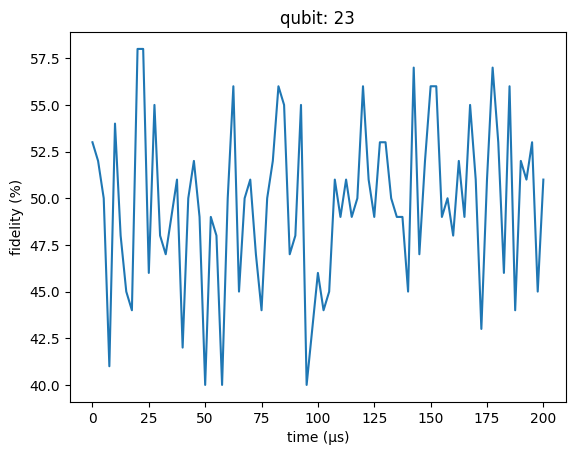

avg: 47.481
std: 5.176


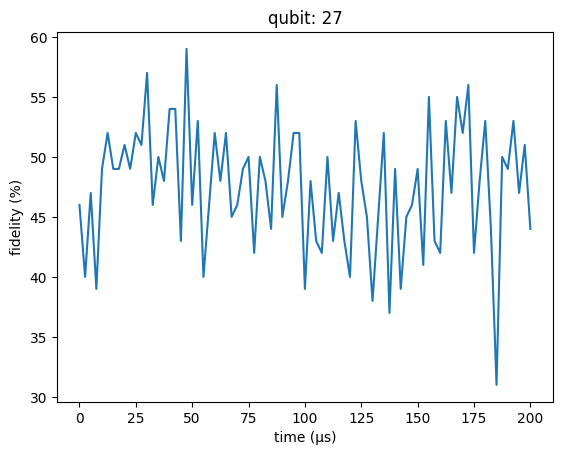

avg: 49.321
std: 4.602


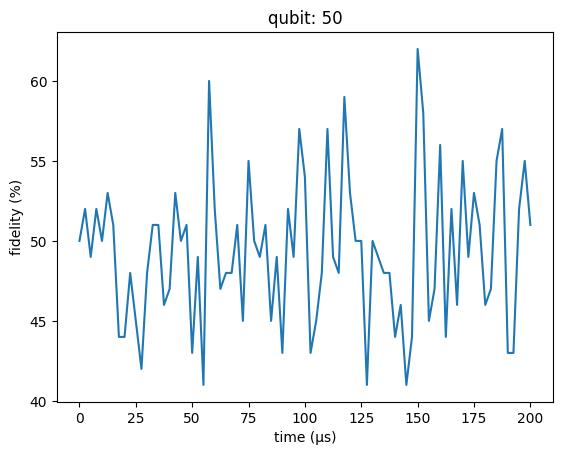

avg: 48.654
std: 4.555


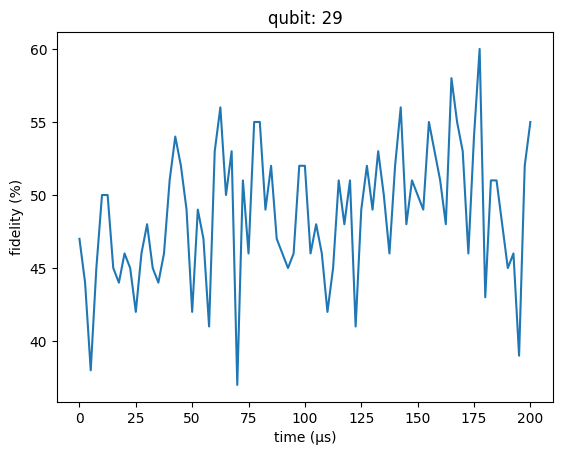

avg: 49.593
std: 4.956


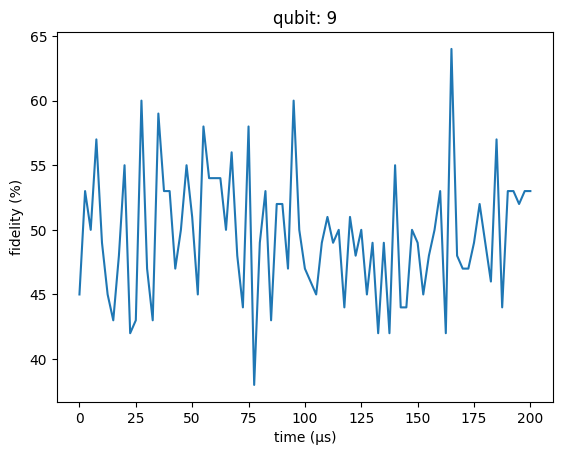

avg: 48.901
std: 4.786


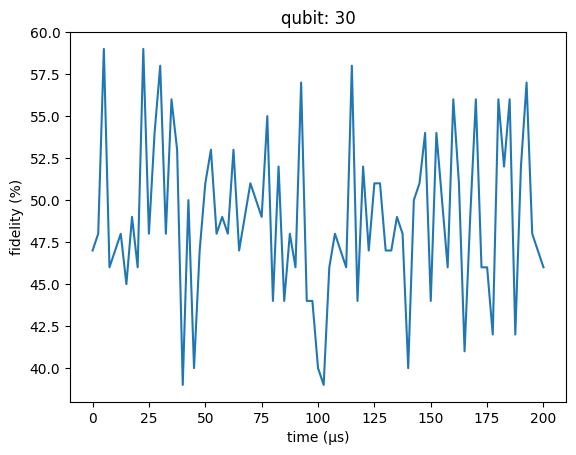

avg: 50.21
std: 4.368


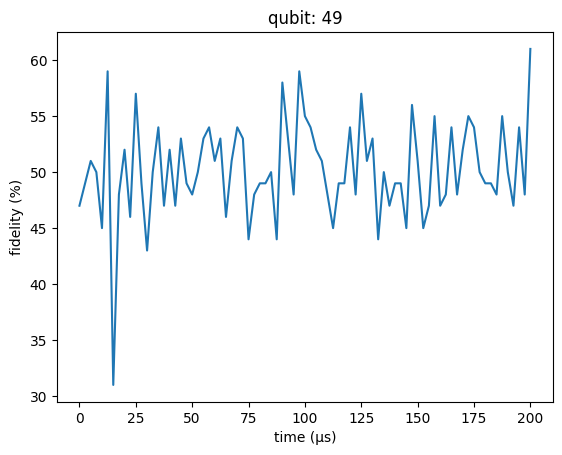

avg: 49.296
std: 4.558


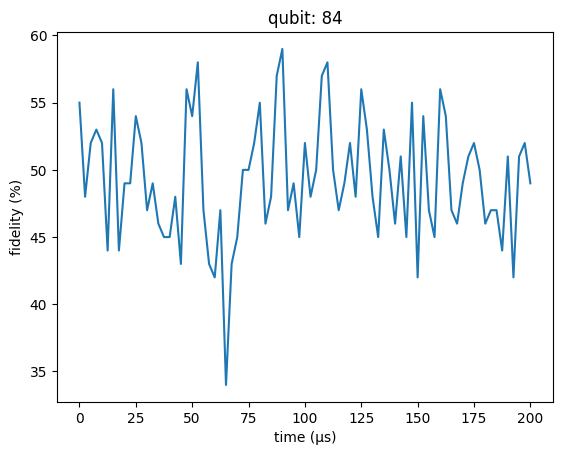

avg: 50.765
std: 5.245


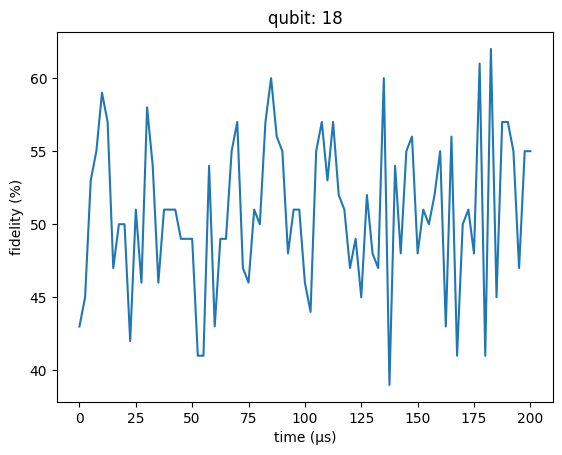

avg: 49.383
std: 4.983


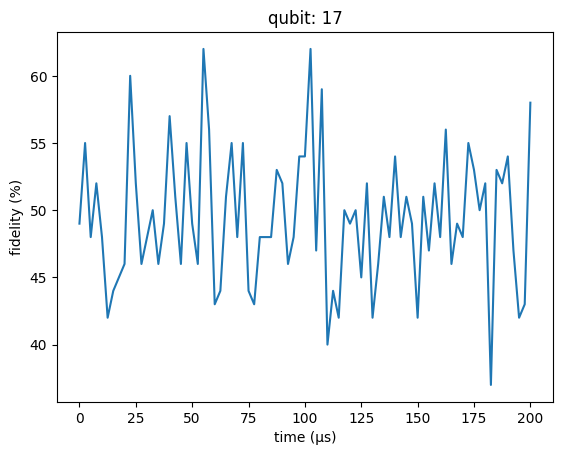

In [14]:
# for q in range(10):
for q in range(10):
    plt.plot(x, y[q])

    # Add labels and title
    plt.xlabel('time (μs)')
    plt.ylabel('fidelity (%)')
    plt.title(f'qubit: {best_T1_qubits[q].Qubit}')
    print(f'avg: {round(np.mean(y[q]),3)}')
    print(f'std: {round(np.std(y[q]),3)}')


    # plt.legend()

    # Display the plot
    plt.show()